In [9]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATv2Conv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns

In [10]:
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [11]:
input_size = 7
hidden_size = 128
output_size = 15

cols = ["ICFC", "MPFL", "GMFIL", "CFCL", "JFL", "NFS", "SFCL", "PROFL", "MFIL", "BFC", "PFL", "GUFL", "RLFL"]
scaler = joblib.load("../scalers/fin.pkl")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load("../models/gcn_fin.pth", map_location=device, weights_only=True))
model = model.to(device)
model.eval()

graphs = torch.load("../graphs/test_graphs/fin_test.pt", weights_only=False)
loader = DataLoader(graphs, batch_size=32, shuffle=False)

c:\Users\acer\anaconda3\envs\env\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
def split_predictions(predictions, cols):
    predictions = np.array(predictions)
    dataframes = []
    for i in range(len(cols)):
        df = pd.DataFrame({
            'col_1': 0,
            'col_2': 0,
            'col_3': 0,
            'Close': predictions[:, i],
            'col_5': 0,
            'col_6': 0,
            'col_7': 0
        })
        dataframes.append(df)
    return dataframes

def generate_predictions(graphs):
    predictions = []
    ground_truth = []
    for batch in graphs:
        batch = batch.to(device)
        with torch.no_grad():
            output = model(batch.x, batch.edge_index, batch.batch)
            output = output.view(-1)
            predictions.append(output.cpu().numpy())
            ground_truth.append(batch.y.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    ground_truth = np.concatenate(ground_truth, axis=0)

    # Reshape to match the original feature dimensions
    predictions = predictions.reshape(-1, output_size)
    ground_truth = ground_truth.reshape(-1, output_size)

    predictions = split_predictions(predictions, cols)
    ground_truth = split_predictions(ground_truth, cols)

    og_cols = predictions[0].columns
    # Inverse transform to the original scale
    predictions_original = [scaler.inverse_transform(prediction) for prediction in predictions]
    ground_truth_original = [scaler.inverse_transform(truth) for truth in ground_truth]

    predictions_original = [pd.DataFrame(df, columns=og_cols) for df in predictions_original]
    ground_truth_original = [pd.DataFrame(df, columns=og_cols) for df in ground_truth_original]

    # Add a 'published_date' column for plotting
    for df in predictions_original:
        df['published_date'] = np.arange(len(df))

    for df in ground_truth_original:
        df['published_date'] = np.arange(len(df))

    return predictions_original, ground_truth_original

In [13]:
test_predictions_df, test_ground_truth_df = generate_predictions(loader)

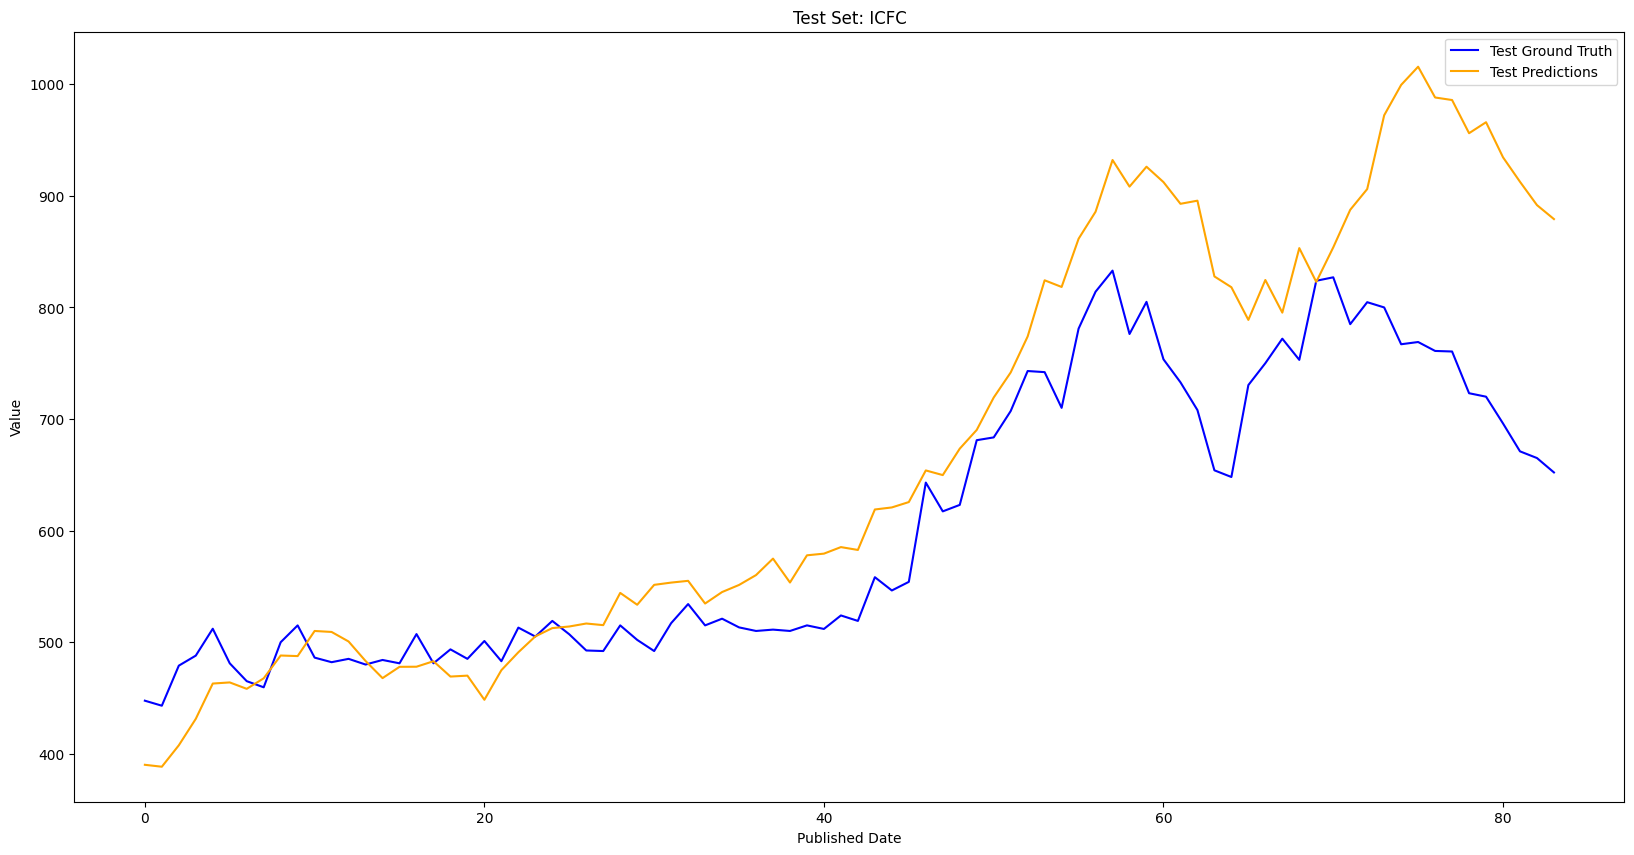

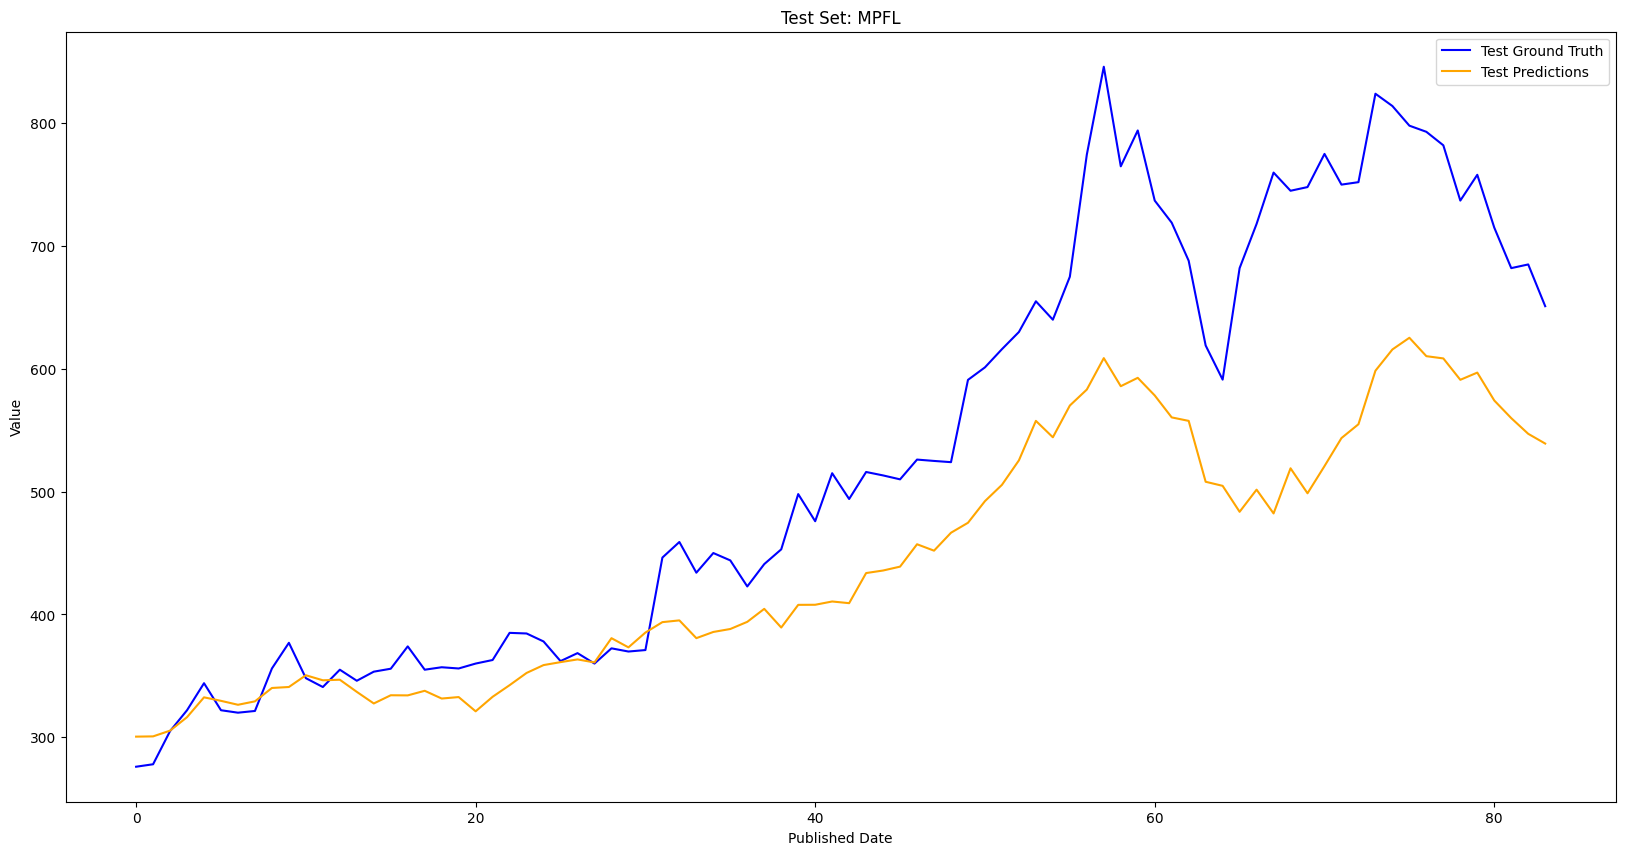

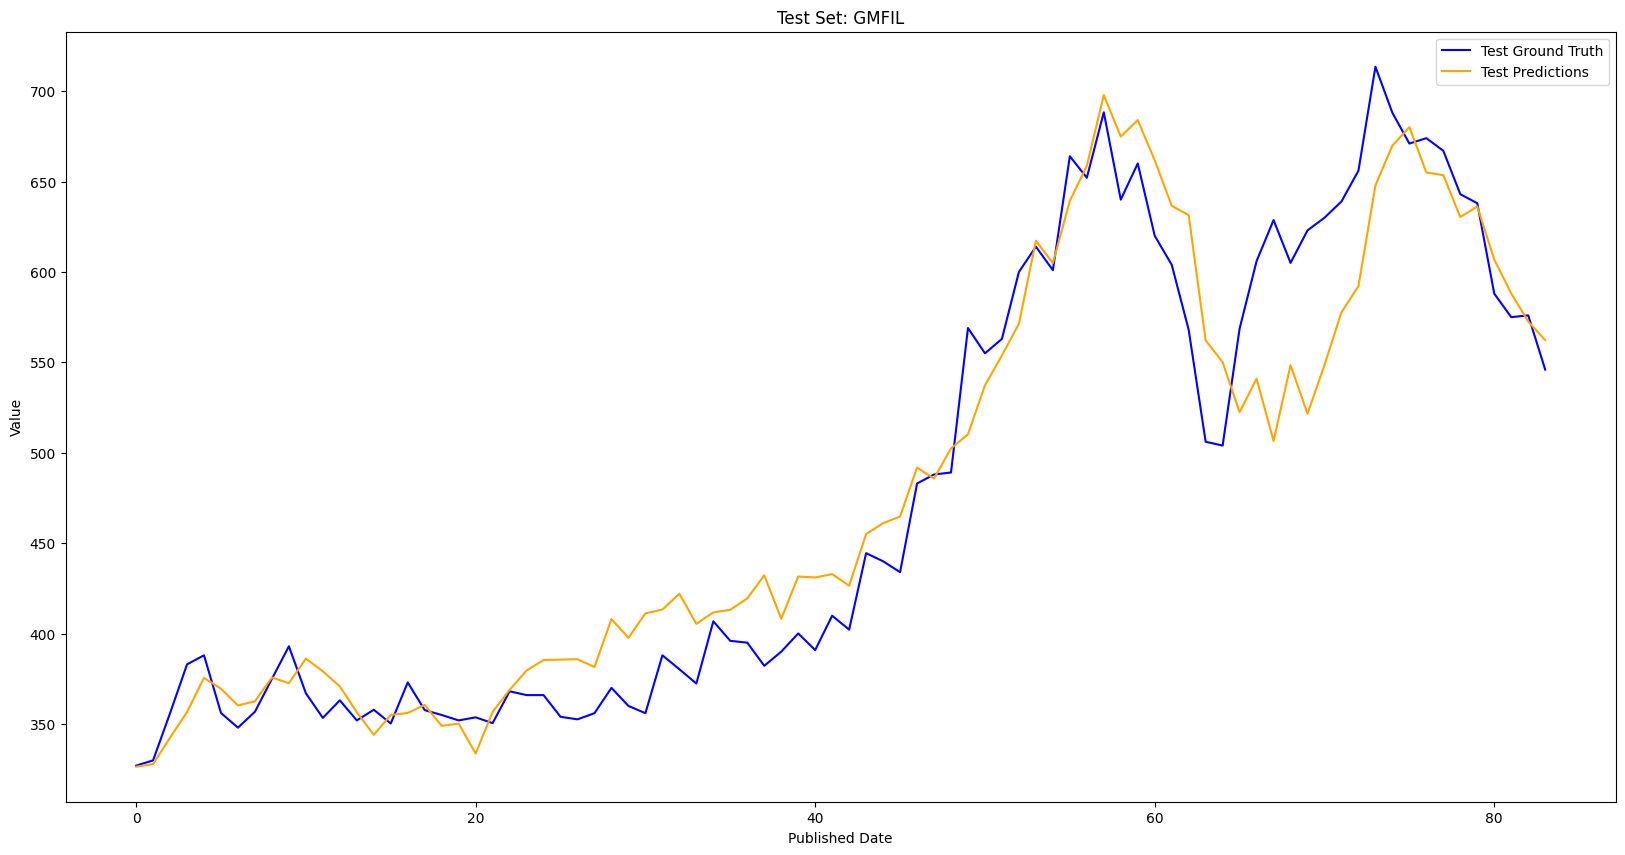

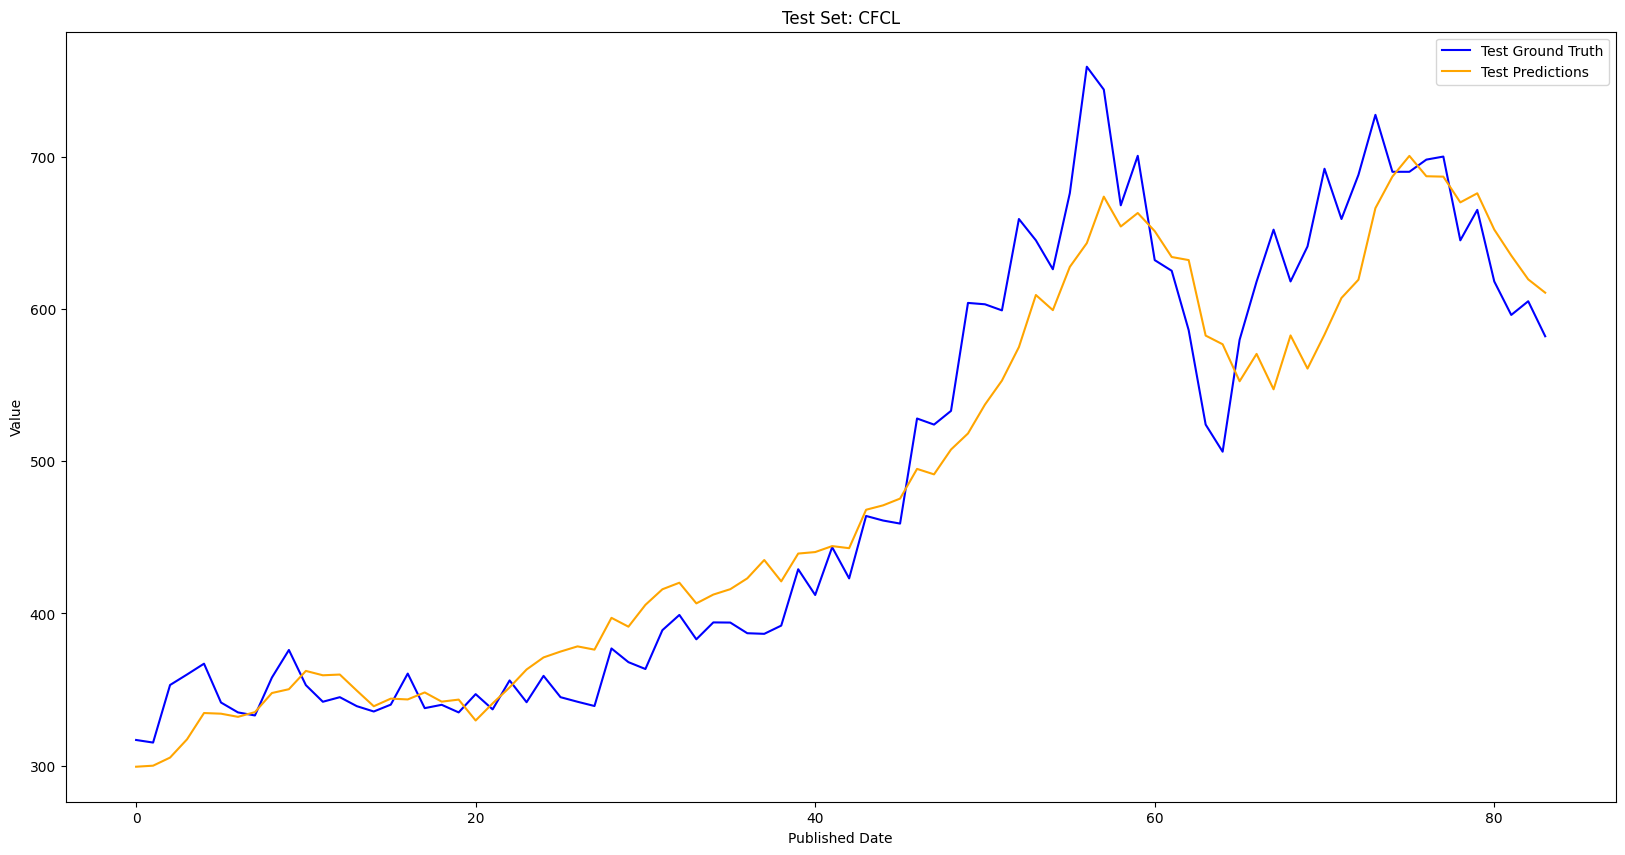

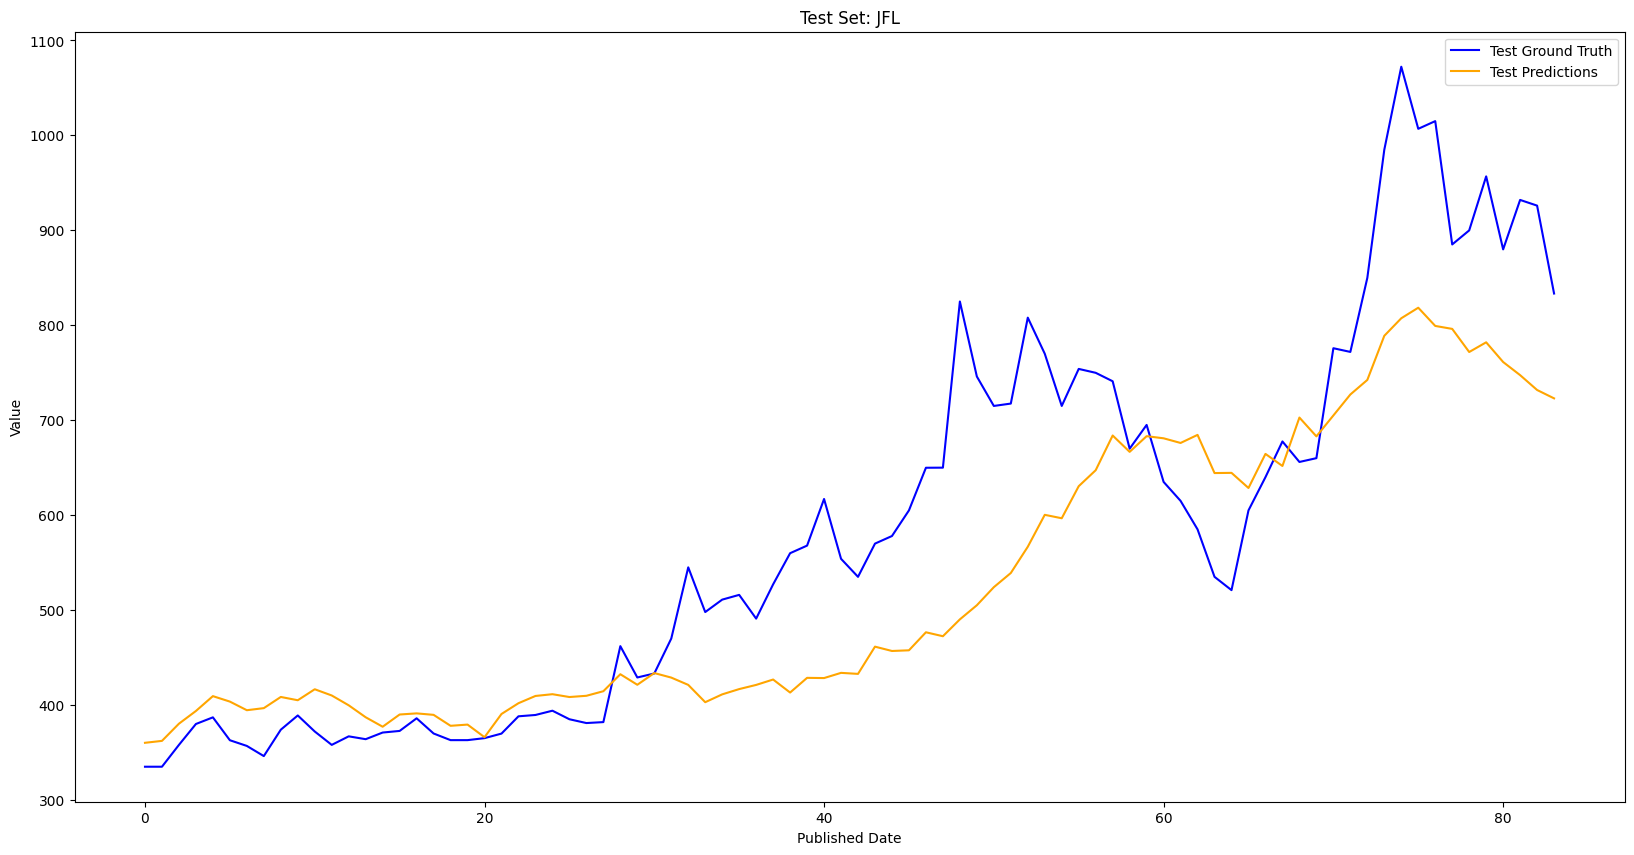

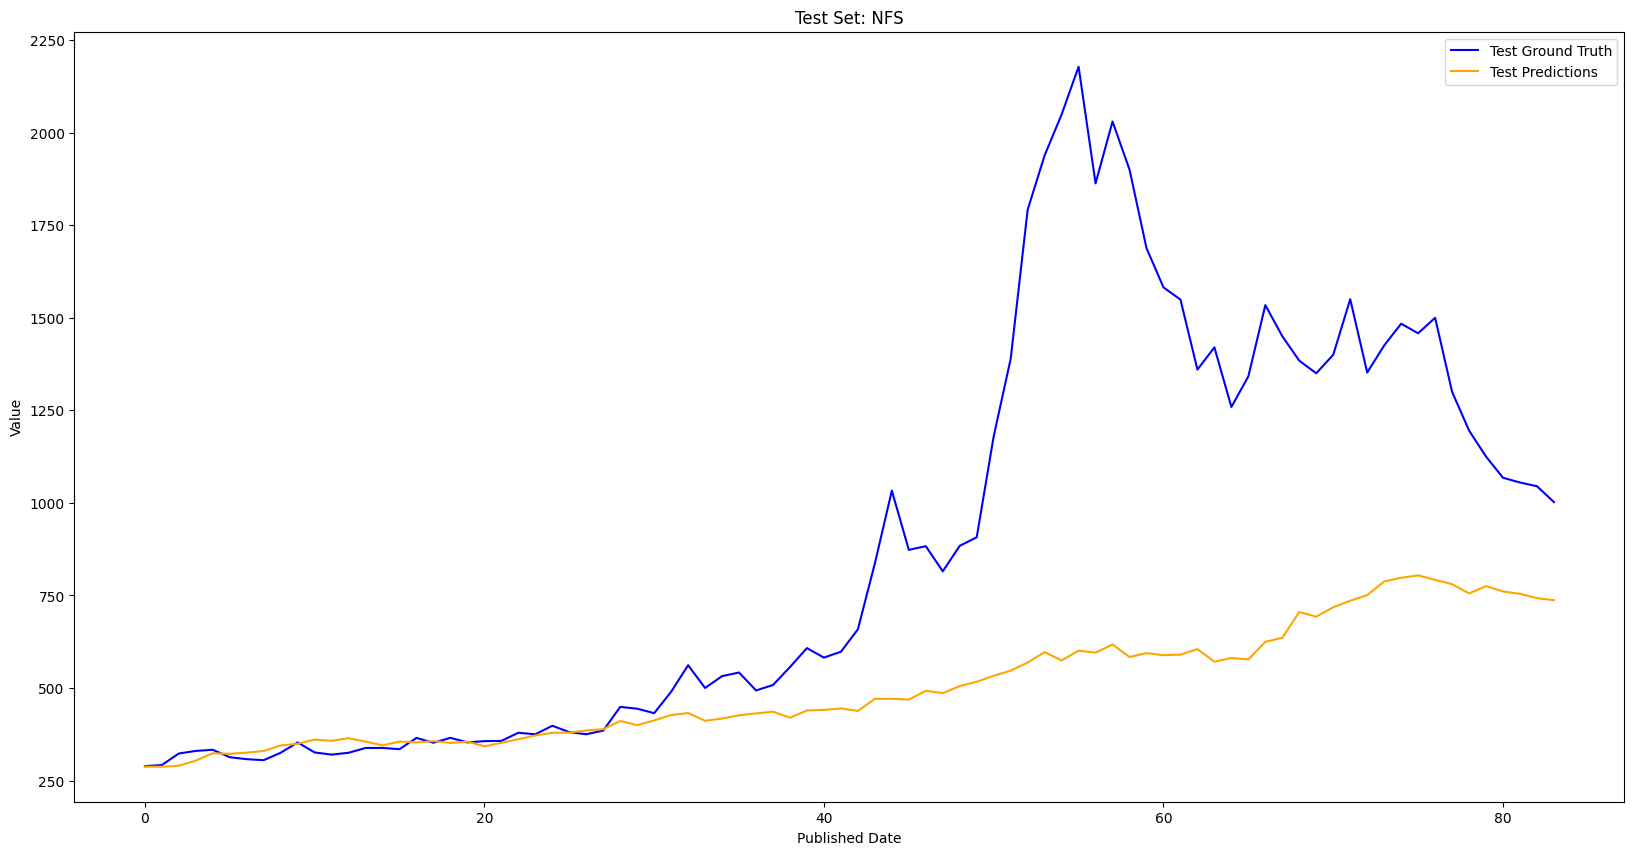

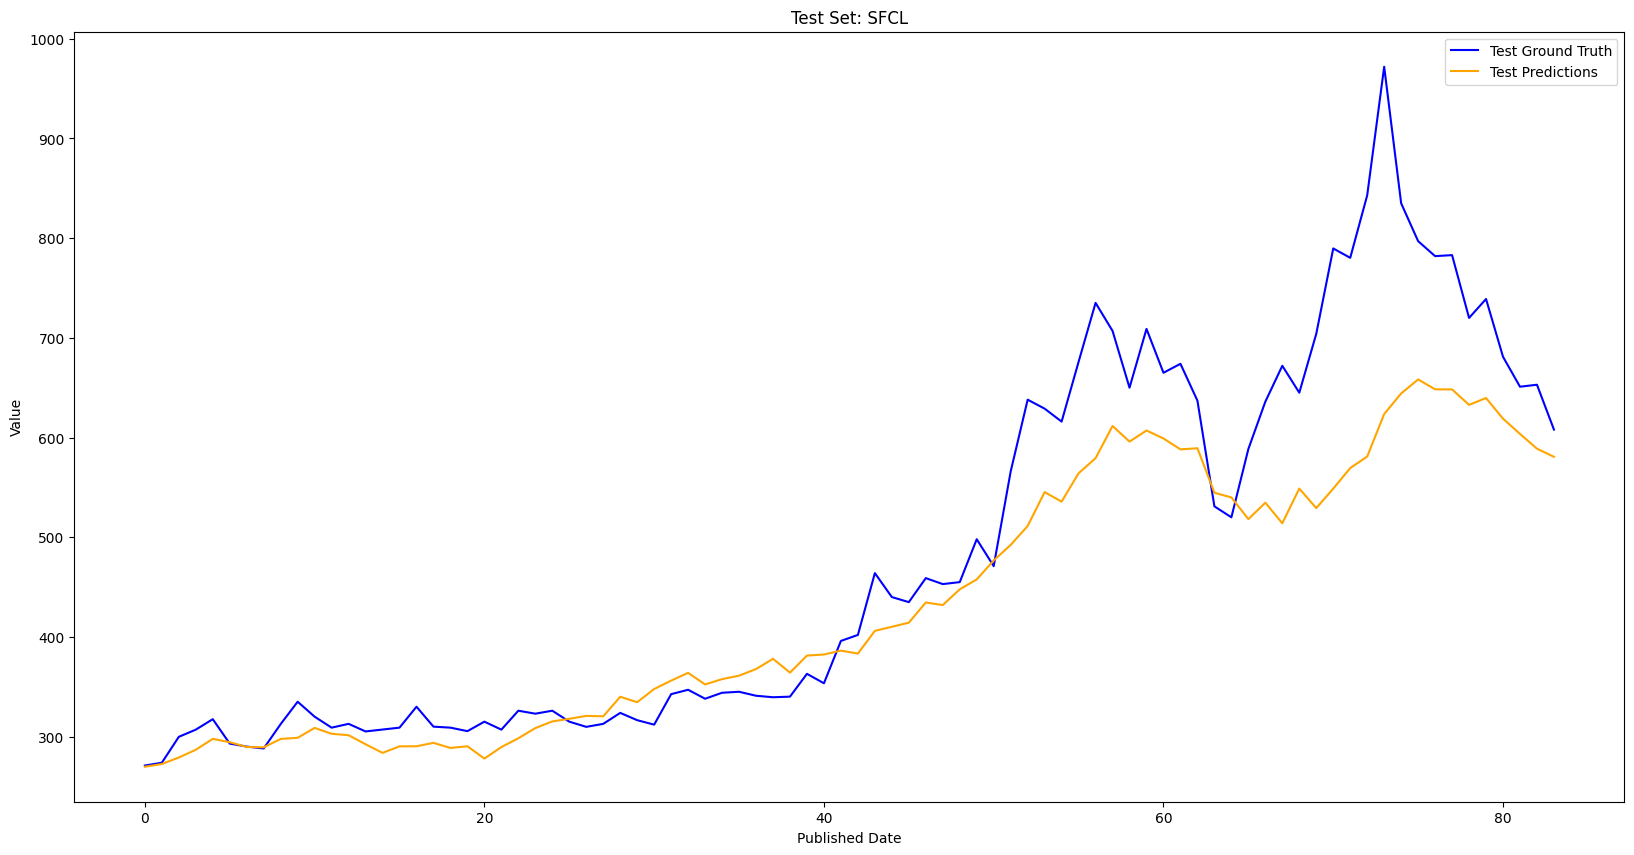

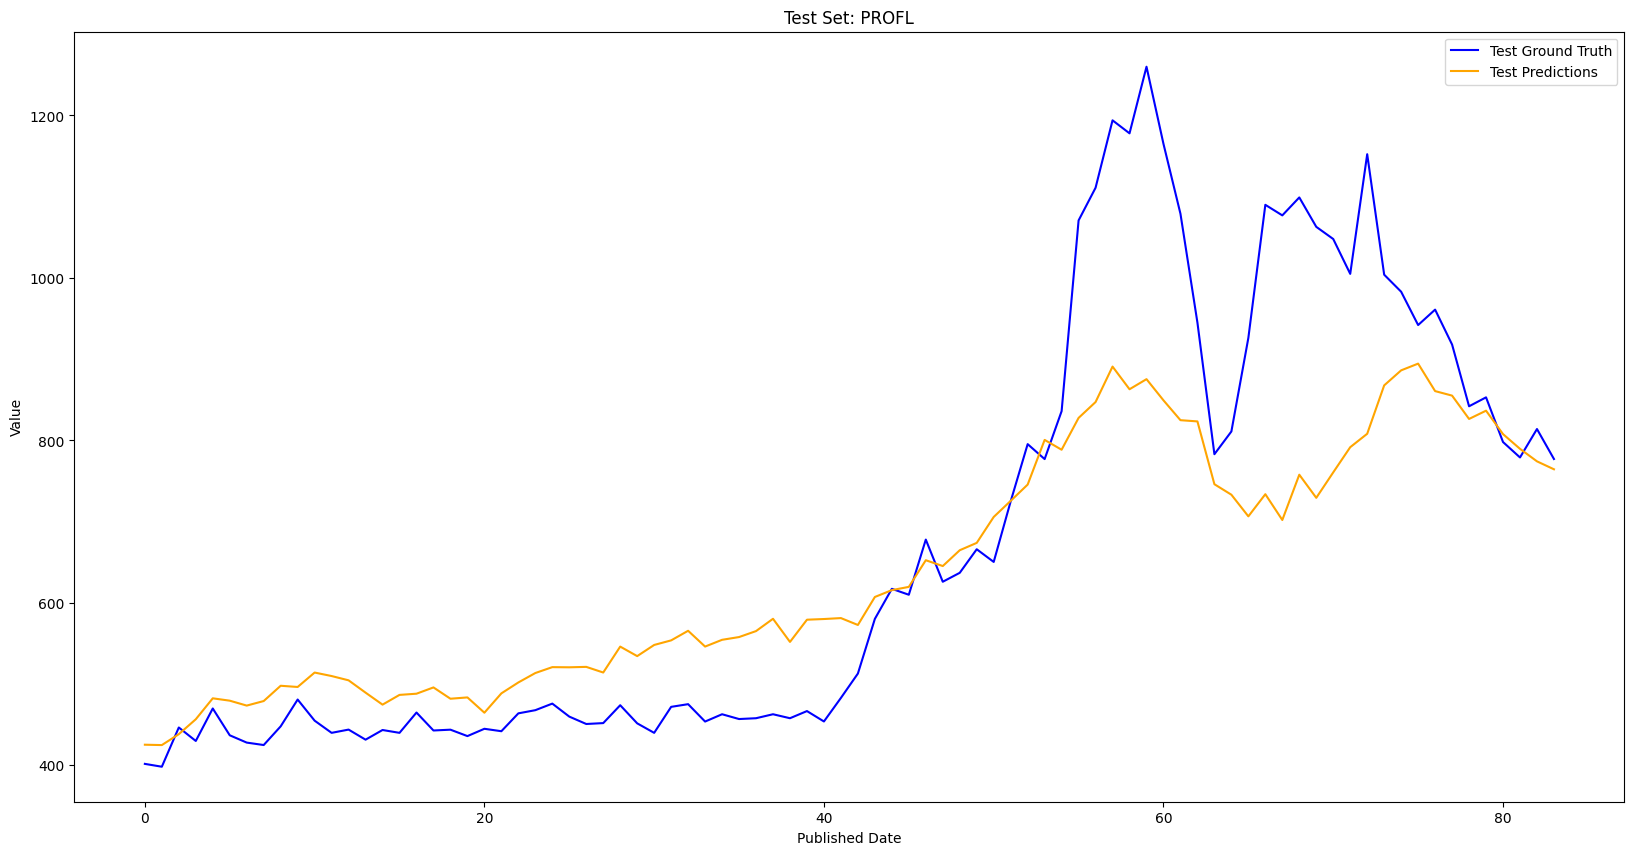

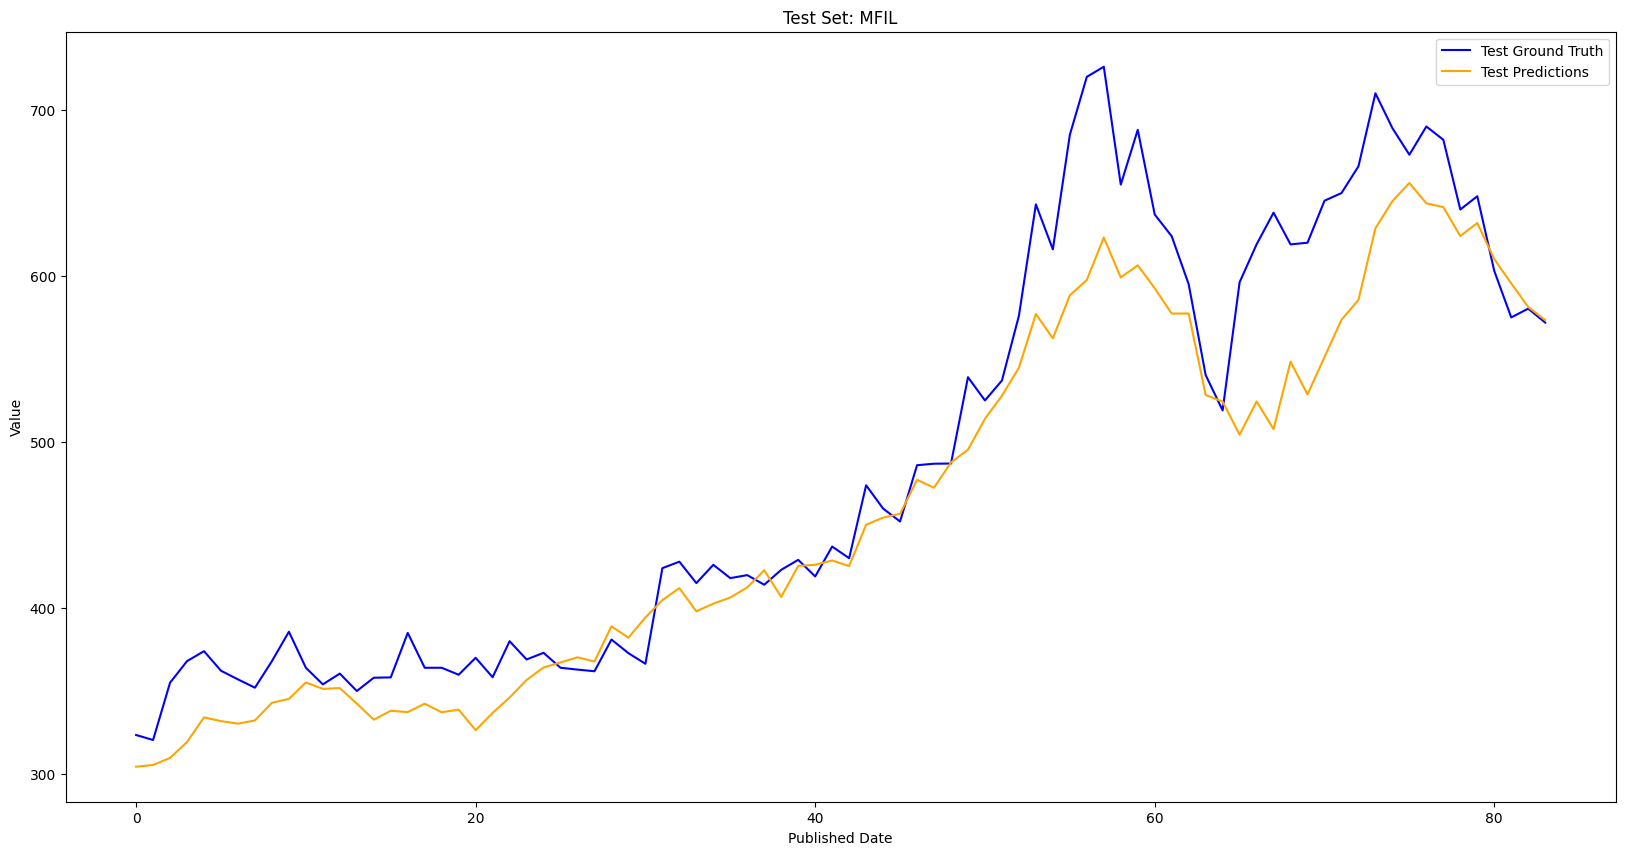

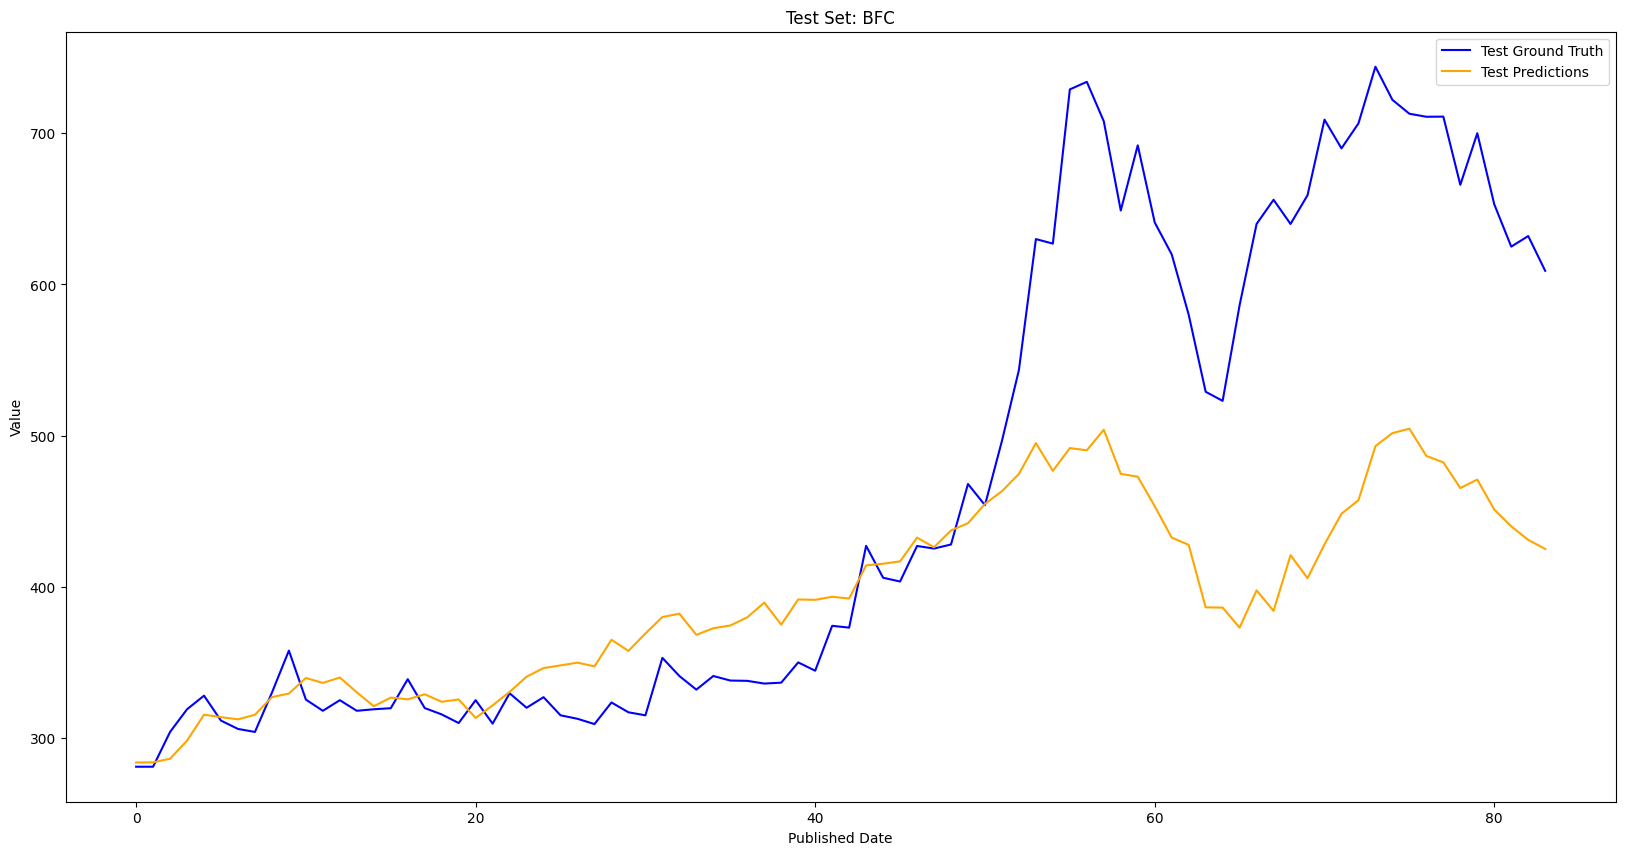

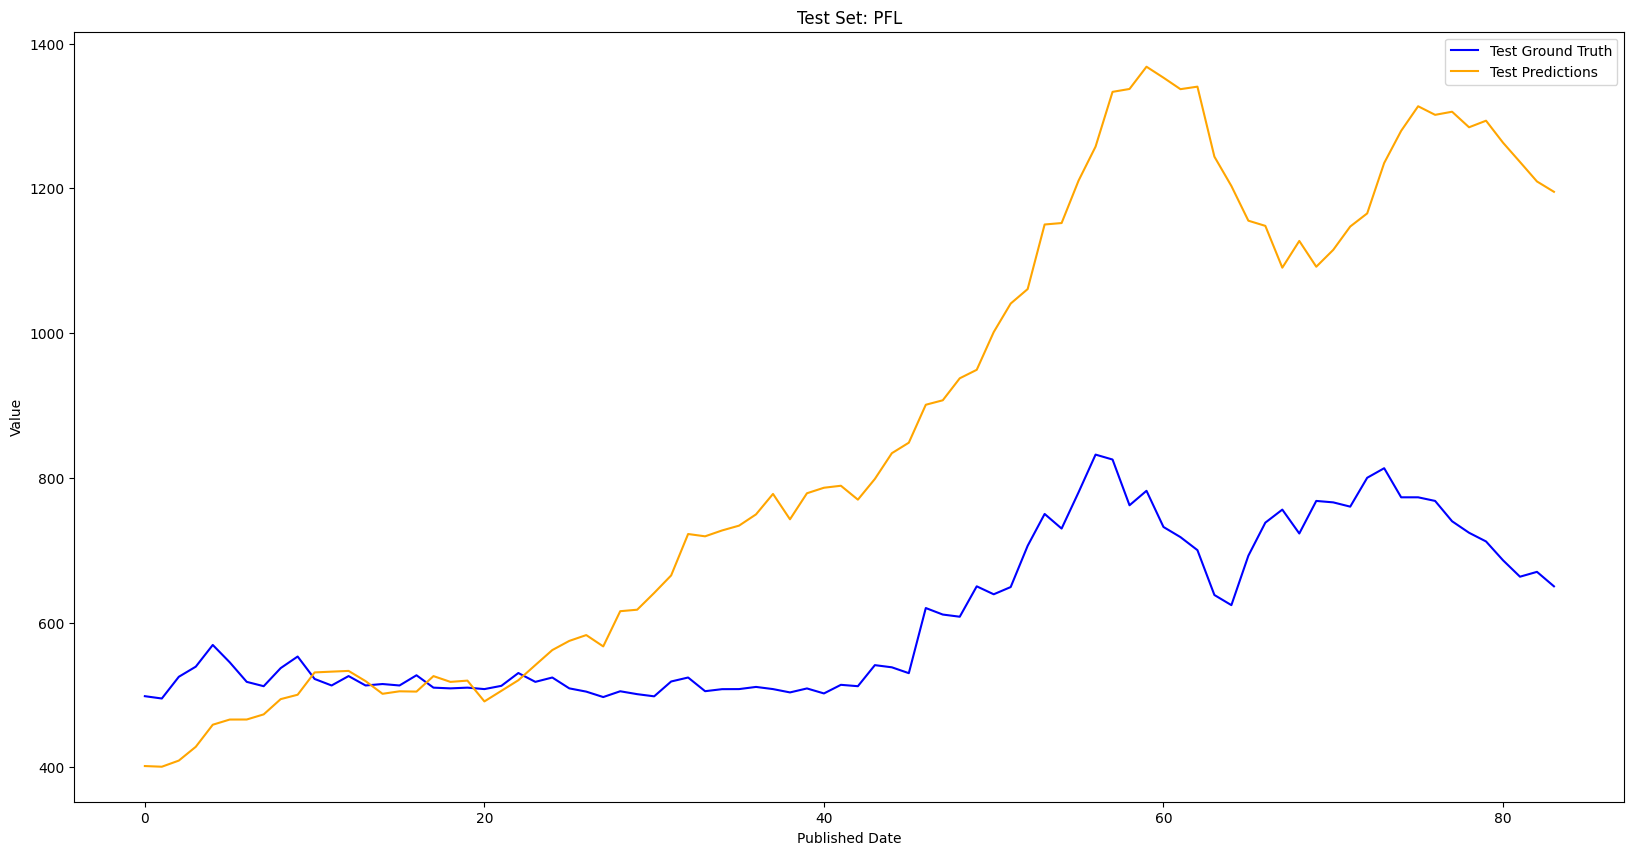

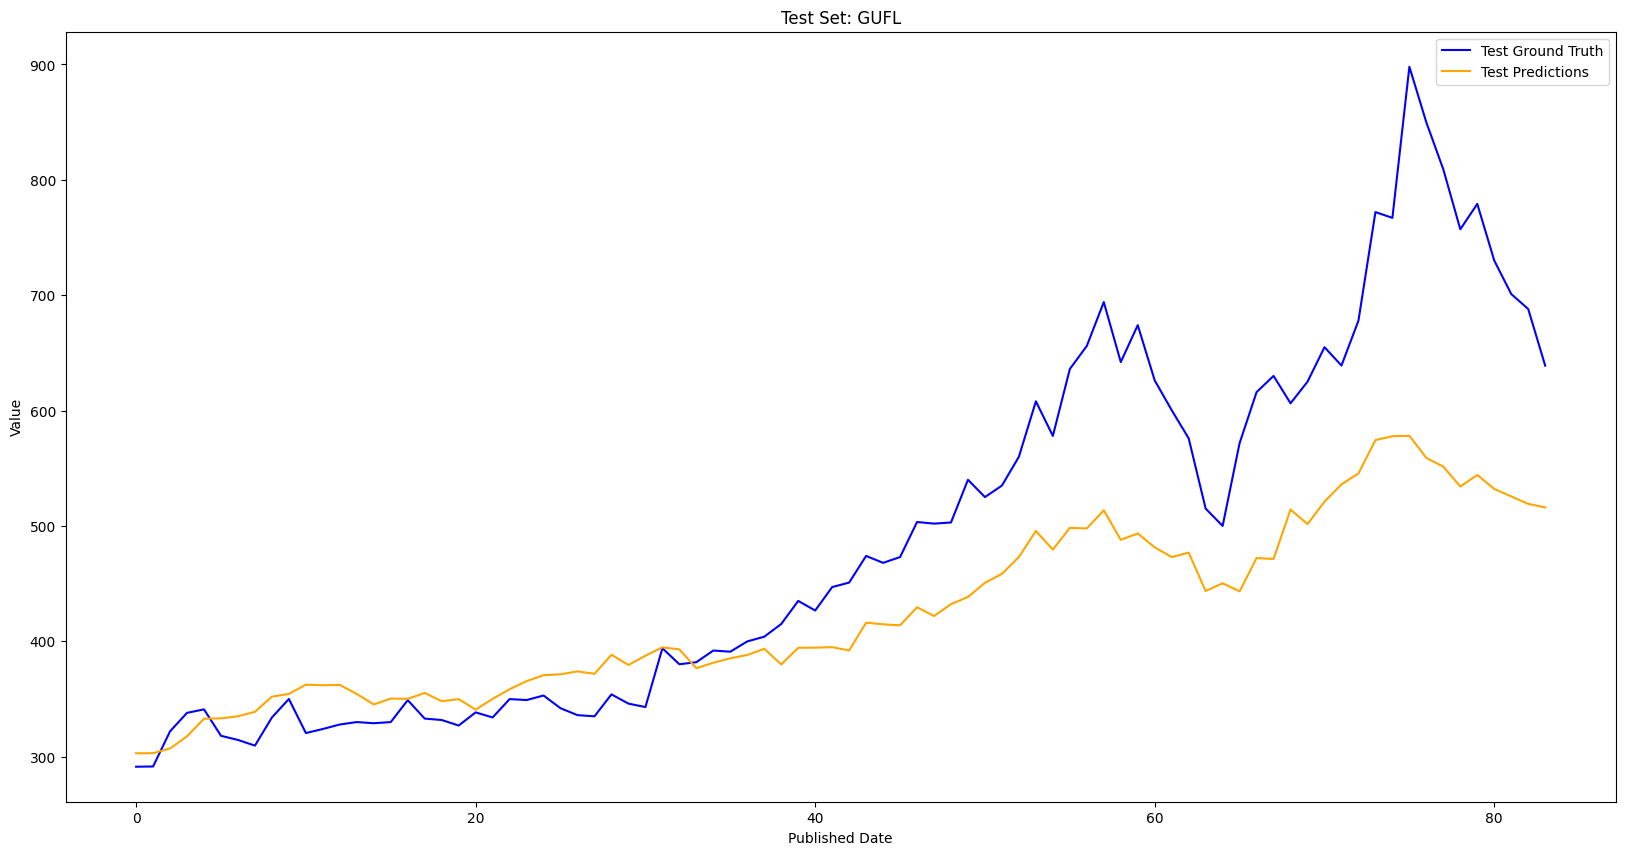

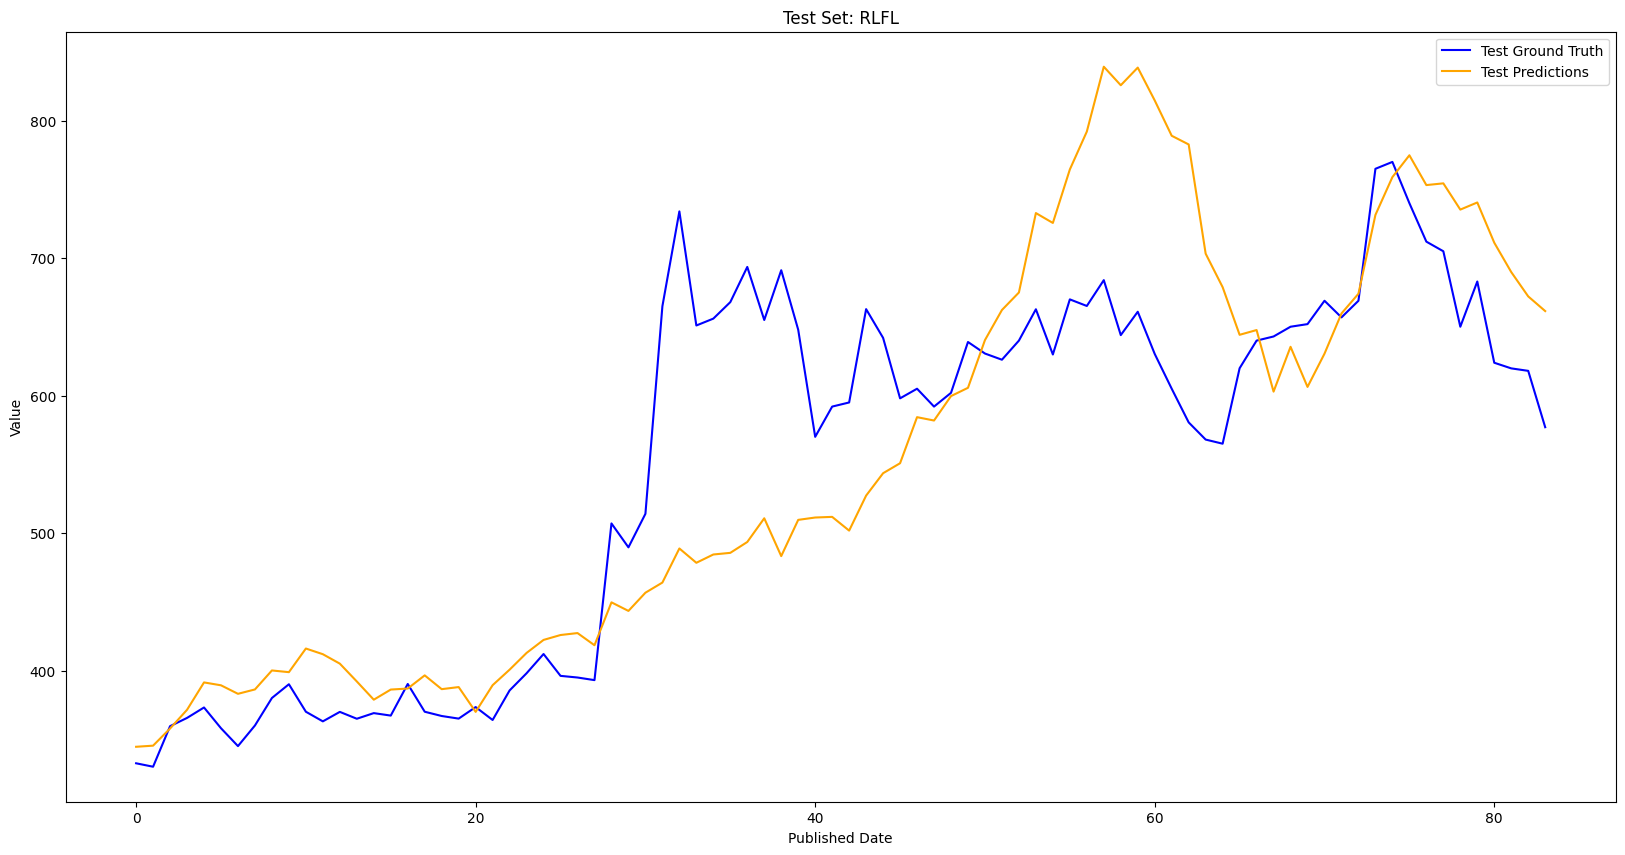

In [14]:
for i, col in enumerate(cols):
    plt.figure(figsize=(20, 10))
    sns.lineplot(data=test_ground_truth_df[i], x='published_date', y="Close", color="blue", label="Test Ground Truth")
    sns.lineplot(data=test_predictions_df[i], x='published_date', y="Close", color="orange", label="Test Predictions")
    plt.title(f"Test Set: {col}")
    plt.xlabel('Published Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()